In [1]:
# For numerical calculations
import numpy as np
import pandas as pd
import scipy as sp
import math
import matplotlib.animation as animation
from scipy.integrate import odeint
from numpy.random import randint
from numpy import arange
from pylab import *
from scipy.integrate import odeint
import scipy.optimize 
from scipy.optimize import leastsq
from math import exp
from collections import OrderedDict
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None
import git

# Find home directory for repo
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

# Import plotting features
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("ticks")
sns.set_palette("colorblind", color_codes=True)
sns.set_context("paper")

# Magic command to plot inline
%matplotlib inline

#To graph in SVG (high def)
%config InlineBackend.figure_format="svg"

In [2]:
# Import table with data
df_data =  pd.read_csv(f'{homedir}/d_alk/data/raw/growth/20210906_growth.csv') 
#See data
df_data.head(200)

,Time_h,Treatment,Timepoint,Replicate,OD600,Cells_ml,Sulfide_mM,Sulfate_mM
0,0.0,High,0.0,1,0.0000,1000000.0,9.853124,0.000000
1,0.0,High,0.0,1,0.0000,1000000.0,9.985991,0.000000
2,0.0,High,0.0,1,0.0000,1000000.0,9.985991,0.000000
3,0.0,High,0.0,2,0.0000,1000000.0,10.202774,0.000000
4,0.0,High,0.0,2,0.0000,1000000.0,10.741235,0.000000
...,...,...,...,...,...,...,...,...
189,52.0,High,NaN,3,0.0271,20700000.0,2.985000,0.000000
190,52.0,High,NaN,3,0.0271,20700000.0,2.764000,0.000000
191,260.0,Medium,NaN,1,0.0975,85000000.0,0.000000,7.019266
192,260.0,Medium,NaN,2,0.0885,85800000.0,0.000000,7.156570


In [3]:
# Calculate the mean and standard deviation                           
df_growth = df_data.groupby(['Treatment', 'Replicate','Time_h']).agg(
                    {'Cells_ml':['mean'],
                     'Sulfide_mM':['mean','std'],
                    'Sulfate_mM':['mean']})
#Change non existing values to 0
#df_growth = df_growth.fillna(0)
#Rename columns after agg
df_growth.columns = ["_".join(x) for x in df_growth.columns.ravel()]
#Drop first level of table after agg
df_growth = df_growth.reset_index()
df_growth

,Treatment,Replicate,Time_h,Cells_ml_mean,Sulfide_mM_mean,Sulfide_mM_std,Sulfate_mM_mean
0,High,1,0.0,1000000.0,9.941702,0.076711,0.000000
1,High,1,36.0,16000000.0,8.846132,0.267019,0.000000
2,High,1,52.0,19800000.0,3.091333,0.033501,0.000000
3,High,1,66.0,23800000.0,0.944042,0.050427,0.000000
4,High,1,97.5,39800000.0,0.760306,0.023867,0.000000
...,...,...,...,...,...,...,...
94,Medium,3,123.0,63000000.0,0.000000,NaN,1.808505
95,Medium,3,147.0,66100000.0,0.000000,NaN,6.309700
96,Medium,3,260.0,87400000.0,0.000000,NaN,7.191262
97,Medium,5,170.0,65900000.0,0.000000,NaN,6.750000


## Plots of cells and concentrations vs. time

### Medium

/Users/dosorior/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/dosorior/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


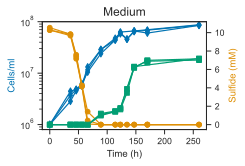

In [4]:
#Make a plot of cells and concentrations vs. time for medium
#Filter by medium
df_medium= df_growth[(df_growth.Treatment == 'Medium')]
# Group by replicate
df_treatments = df_medium.groupby(['Replicate'])
# Define colors
colors = sns.color_palette('colorblind', n_colors=5)
# Define markers
markers = ['d', 'o','s']

# Define fig and axes
#fig, ax = plt.subplots(1,7, figsize=(9,6))
fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

for i, (group, data) in enumerate(df_treatments):
    #print(group, data)
    ax.errorbar(data.Time_h, data.Cells_ml_mean,color=colors[0], marker=markers[0], label = group)
    ax2.errorbar(data.Time_h, data.Sulfide_mM_mean, yerr=data.Sulfide_mM_std, color=colors[1], marker=markers[1], label = group)
    ax2.errorbar(data.Time_h, data.Sulfate_mM_mean, color=colors[2], marker=markers[2])
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Cells/ml', color = colors[0])
    ax2.set_ylabel('Sulfide (mM)', color=colors[1])
    ax.set_title('Medium', size=12)
    ax.set_yscale('log')
    ax.set_ylim([8e5, 1e8])

#Show legend
#plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0.)
#Save figure
#fig.savefig(f'{homedir}/d_alk/figures/Medium.pdf', bbox_inches='tight')

In [172]:
#Get growth rates for medium
#Filter medium dataframe for exponential phase only
df_medium_exp_mean = df_medium[(df_medium.Time_h <= 100)]
df_medium_exp_mean.head()

,Treatment,Replicate,Time_h,Cells_ml_mean,Sulfide_mM_mean,Sulfide_mM_std,Sulfate_mM_mean
60,Medium,1,0.0,1000000.0,11.541933,0.113730,0.0
61,Medium,1,36.0,3700000.0,9.828648,0.054393,0.0
62,Medium,1,46.0,4800000.0,7.598333,0.043844,NaN
63,Medium,1,56.0,6240000.0,4.274333,0.111509,NaN
64,Medium,1,66.0,10500000.0,1.414904,0.044959,0.0


In [73]:
#Get growth rates for the entire exponential phase
#Filter medium dataframe for exponential phase only (t=0 and t=36h)
df_medium_exp = df_medium[(df_medium.Time_h == 0) | (df_medium.Time_h == 36)]
df_medium_exp.head(20)

,Treatment,Replicate,Time_h,Cells_ml_mean,Sulfide_mM_mean,Sulfide_mM_std,Sulfate_mM_mean
63,Medium,1,0.0,1000000.0,10.541933,0.113730,0.0
64,Medium,1,36.0,3700000.0,9.828648,0.054393,0.0
74,Medium,2,0.0,1000000.0,10.277366,0.107504,0.0
75,Medium,2,36.0,4440000.0,9.821656,0.153289,0.0
85,Medium,3,0.0,1000000.0,10.277366,0.107504,0.0
86,Medium,3,36.0,2840000.0,9.678299,0.079117,0.0


In [74]:
#Get ratios of cells/ml calculated from chlorophyll between timepoints for each ID and Replicate
df_medium_exp['ratio_cells'] = df_medium_exp['Cells_ml_mean'].div(df_medium_exp.groupby(['Treatment'])['Cells_ml_mean'].shift(1)).fillna(0) 
#Get differences between timepoints for each treatment and Replicate
df_medium_exp['diff_time_h'] = df_medium_exp.groupby(['Treatment','Replicate'])['Time_h'].diff().fillna(0)
#Get differences between cells/ml between timepoints for each treatment and Replicate
df_medium_exp['diff_cells'] = df_medium_exp.groupby(['Treatment','Replicate'])['Cells_ml_mean'].diff().fillna(0)
#Get differences between sulfide concentrations between timepoints for each ID and Replicate
df_medium_exp['diff_sulfide_mM'] = df_medium_exp.groupby(['Treatment','Replicate'])['Sulfide_mM_mean'].diff().fillna(0)
#Calculate growth rates in day^-1
df_medium_exp['growth_rate'] = np.log(df_medium_exp['ratio_cells'])*24/df_medium_exp['diff_time_h']
#Get maximum growth rates per ID and Replicate
df_medium_exp['max_growth_rate']= df_medium_exp.groupby(['Treatment','Replicate'])['growth_rate'].transform(max)
#Determine csSOR
df_medium_exp['csSOR'] = -(df_medium_exp['max_growth_rate']*df_medium_exp['diff_sulfide_mM']*10**9)/df_medium_exp['diff_cells']
#See dataframe
df_medium_exp

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Treatment,Replicate,Time_h,Cells_ml_mean,Sulfide_mM_mean,Sulfide_mM_std,Sulfate_mM_mean,ratio_cells,diff_time_h,diff_cells,diff_sulfide_mM,growth_rate,max_growth_rate,csSOR
63,Medium,1,0.0,1000000.0,10.541933,0.113730,0.0,0.000000,0.0,0.0,0.000000,-inf,0.872222,NaN
64,Medium,1,36.0,3700000.0,9.828648,0.054393,0.0,3.700000,36.0,2700000.0,-0.713285,0.872222,0.872222,230.423253
74,Medium,2,0.0,1000000.0,10.277366,0.107504,0.0,0.270270,0.0,0.0,0.000000,-inf,0.993770,NaN
75,Medium,2,36.0,4440000.0,9.821656,0.153289,0.0,4.440000,36.0,3440000.0,-0.455710,0.993770,0.993770,131.648615
85,Medium,3,0.0,1000000.0,10.277366,0.107504,0.0,0.225225,0.0,0.0,0.000000,-inf,0.695869,NaN
86,Medium,3,36.0,2840000.0,9.678299,0.079117,0.0,2.840000,36.0,1840000.0,-0.599067,0.695869,0.695869,226.561073


In [75]:
# Calculate the mean and standard deviation  
df_medium_exp_36 = df_medium_exp[(df_medium_exp.Time_h == 36)]
df_stats_medium = df_medium_exp_36.agg(
                    {'max_growth_rate':['mean','std'],
                     'csSOR':['mean','std']})
df_stats_medium

,max_growth_rate,csSOR
mean,0.853954,196.210980
std,0.149788,55.945987


### Lower

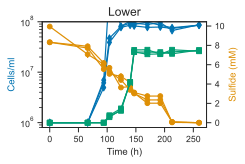

In [51]:
#Make a plot of cells and concentrations vs. time for medium
#Filter by medium
df_lower= df_growth[(df_growth.Treatment == 'Lower')]
# Group by replicate
df_treatments = df_lower.groupby(['Replicate'])
# Define colors
colors = sns.color_palette('colorblind', n_colors=5)
# Define markers
markers = ['d', 'o','s']

# Define fig and axes
#fig, ax = plt.subplots(1,7, figsize=(9,6))
fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

for i, (group, data) in enumerate(df_treatments):
    #print(group, data)
    ax.errorbar(data.Time_h, data.Cells_ml_mean,color=colors[0], marker=markers[0], label = group)
    ax2.errorbar(data.Time_h, data.Sulfide_mM_mean, yerr=data.Sulfide_mM_std, color=colors[1], marker=markers[1], label = group)
    ax2.errorbar(data.Time_h, data.Sulfate_mM_mean, color=colors[2], marker=markers[2])
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Cells/ml', color = colors[0])
    ax2.set_ylabel('Sulfide (mM)', color=colors[1])
    ax.set_title('Lower', size=12)
    ax.set_yscale('log')
    ax.set_ylim([8e5, 1e8])

#Show legend
#plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0.)
#Save figure
fig.savefig(f'{homedir}/d_alk/figures/Lower.pdf', bbox_inches='tight')

In [58]:
#Get growth rates for the entire exponential phase
#Filter low dataframe for exponential phase only (t=0 and t=36h)
df_lower_exp = df_lower[(df_lower.Time_h == 66) | (df_lower.Time_h == 94)]
df_lower_exp.head(20)

,Treatment,Replicate,Time_h,Cells_ml_mean,Sulfide_mM_mean,Sulfide_mM_std,Sulfate_mM_mean
31,Lower,1,66.0,1000000.0,7.719793,0.165841,0.0
32,Lower,1,94.0,4960000.0,5.538834,0.155529,0.0
42,Lower,2,66.0,1000000.0,7.072241,0.378678,0.0
43,Lower,2,94.0,6160000.0,6.042358,0.184176,0.0
53,Lower,3,66.0,1000000.0,7.904408,0.260186,0.0
54,Lower,3,94.0,6960000.0,6.172199,0.294651,0.0


In [59]:
#Get ratios of cells/ml calculated from chlorophyll between timepoints for each ID and Replicate
df_lower_exp['ratio_cells'] = df_lower_exp['Cells_ml_mean'].div(df_lower_exp.groupby(['Treatment','Replicate'])['Cells_ml_mean'].shift(1)).fillna(0) 
#Get differences between timepoints for each treatment and Replicate
df_lower_exp['diff_time_h'] = df_lower_exp.groupby(['Treatment','Replicate'])['Time_h'].diff().fillna(0)
#Get differences between cells/ml between timepoints for each treatment and Replicate
df_lower_exp['diff_cells'] = df_lower_exp.groupby(['Treatment','Replicate'])['Cells_ml_mean'].diff().fillna(0)
#Get differences between sulfide concentrations between timepoints for each ID and Replicate
df_lower_exp['diff_sulfide_mM'] = df_lower_exp.groupby(['Treatment','Replicate'])['Sulfide_mM_mean'].diff().fillna(0)
#Calculate growth rates in day^-1
df_lower_exp['growth_rate'] = np.log(df_lower_exp['ratio_cells'])*24/df_lower_exp['diff_time_h']
#Get maximum growth rates per ID and Replicate
df_lower_exp['max_growth_rate']= df_lower_exp.groupby(['Treatment','Replicate'])['growth_rate'].transform(max)
#Determine csSOR
df_lower_exp['csSOR'] = -(df_lower_exp['max_growth_rate']*df_lower_exp['diff_sulfide_mM']*10**9)/df_lower_exp['diff_cells']
#See dataframe
df_lower_exp

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Treatment,Replicate,Time_h,Cells_ml_mean,Sulfide_mM_mean,Sulfide_mM_std,Sulfate_mM_mean,ratio_cells,diff_time_h,diff_cells,diff_sulfide_mM,growth_rate,max_growth_rate,csSOR
31,Lower,1,66.0,1000000.0,7.719793,0.165841,0.0,0.00,0.0,0.0,0.000000,-inf,1.372633,NaN
32,Lower,1,94.0,4960000.0,5.538834,0.155529,0.0,4.96,28.0,3960000.0,-2.180959,1.372633,1.372633,755.974106
42,Lower,2,66.0,1000000.0,7.072241,0.378678,0.0,0.00,0.0,0.0,0.000000,-inf,1.558352,NaN
43,Lower,2,94.0,6160000.0,6.042358,0.184176,0.0,6.16,28.0,5160000.0,-1.029883,1.558352,1.558352,311.030998
53,Lower,3,66.0,1000000.0,7.904408,0.260186,0.0,0.00,0.0,0.0,0.000000,-inf,1.663011,NaN
54,Lower,3,94.0,6960000.0,6.172199,0.294651,0.0,6.96,28.0,5960000.0,-1.732209,1.663011,1.663011,483.336022


In [86]:
# Calculate the mean and standard deviation  
df_lower_exp_36 = df_lower_exp[(df_lower_exp.Time_h == 94) & (df_lower_exp.Replicate != 1)]
df_stats_lower = df_lower_exp_36.agg(
                    {'max_growth_rate':['mean','std'],
                     'csSOR':['mean','std']})
df_stats_lower

,max_growth_rate,csSOR
mean,1.610681,397.183510
std,0.074005,121.838051


### High

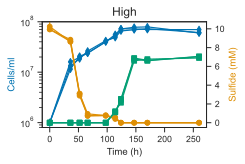

In [82]:
#Make a plot of cells and concentrations vs. time for High
#Filter by High
df_high= df_growth[(df_growth.Treatment == 'High')]
# Group by replicate
df_treatments = df_high.groupby(['Replicate'])
# Define colors
colors = sns.color_palette('colorblind', n_colors=4)
# Define markers
markers = ['d', 'o', 's']

# Define fig and axes
#fig, ax = plt.subplots(1,7, figsize=(9,6))
fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

for i, (group, data) in enumerate(df_treatments):
    #print(group, data)
    ax.errorbar(data.Time_h, data.Cells_ml_mean,color=colors[0], marker=markers[0], label = group)
    ax2.errorbar(data.Time_h, data.Sulfide_mM_mean, yerr=data.Sulfide_mM_std, color=colors[1], marker=markers[1], label = group)
    ax2.errorbar(data.Time_h, data.Sulfate_mM_mean, color=colors[2], marker=markers[2])
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Cells/ml', color = colors[0])
    ax2.set_ylabel('Sulfide (mM)', color=colors[1])
    ax.set_title('High', size=12)
    ax.set_yscale('log')
    ax.set_ylim([8e5, 1e8])

#Show legend
#plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0.)
#Save figure
fig.savefig(f'{homedir}/d_alk/figures/High.pdf', bbox_inches='tight')

In [83]:
#Get growth rates for the entire exponential phase
#Filter high dataframe for exponential phase only (t=0 and t=36h)
df_high_exp = df_high[(df_high.Time_h == 0) | (df_high.Time_h == 36)]
df_high_exp.head(20)

,Treatment,Replicate,Time_h,Cells_ml_mean,Sulfide_mM_mean,Sulfide_mM_std,Sulfate_mM_mean
0,High,1,0.0,1000000.0,9.941702,0.076711,0.0
1,High,1,36.0,16000000.0,8.846132,0.267019,0.0
10,High,2,0.0,1000000.0,10.242401,0.480248,0.0
11,High,2,36.0,13300000.0,8.622354,NaN,0.0
20,High,3,0.0,1000000.0,9.941702,0.076711,0.0
21,High,3,36.0,11500000.0,8.657320,0.306577,0.0


In [84]:
#Get ratios of cells/ml calculated from chlorophyll between timepoints for each ID and Replicate
df_high_exp['ratio_cells'] = df_high_exp['Cells_ml_mean'].div(df_high_exp.groupby(['Treatment','Replicate'])['Cells_ml_mean'].shift(1)).fillna(0) 
#Get differences between timepoints for each treatment and Replicate
df_high_exp['diff_time_h'] = df_high_exp.groupby(['Treatment','Replicate'])['Time_h'].diff().fillna(0)
#Get differences between cells/ml between timepoints for each treatment and Replicate
df_high_exp['diff_cells'] = df_high_exp.groupby(['Treatment','Replicate'])['Cells_ml_mean'].diff().fillna(0)
#Get differences between sulfide concentrations between timepoints for each ID and Replicate
df_high_exp['diff_sulfide_mM'] = df_high_exp.groupby(['Treatment','Replicate'])['Sulfide_mM_mean'].diff().fillna(0)
#Calculate growth rates in day^-1
df_high_exp['growth_rate'] = np.log(df_high_exp['ratio_cells'])*24/df_high_exp['diff_time_h']
#Get maximum growth rates per ID and Replicate
df_high_exp['max_growth_rate']= df_high_exp.groupby(['Treatment','Replicate'])['growth_rate'].transform(max)
#Determine csSOR
df_high_exp['csSOR'] = -(df_high_exp['max_growth_rate']*df_high_exp['diff_sulfide_mM']*10**9)/df_high_exp['diff_cells']
#See dataframe
df_high_exp

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Treatment,Replicate,Time_h,Cells_ml_mean,Sulfide_mM_mean,Sulfide_mM_std,Sulfate_mM_mean,ratio_cells,diff_time_h,diff_cells,diff_sulfide_mM,growth_rate,max_growth_rate,csSOR
0,High,1,0.0,1000000.0,9.941702,0.076711,0.0,0.0,0.0,0.0,0.000000,-inf,1.848392,NaN
1,High,1,36.0,16000000.0,8.846132,0.267019,0.0,16.0,36.0,15000000.0,-1.095570,1.848392,1.848392,135.002890
10,High,2,0.0,1000000.0,10.242401,0.480248,0.0,0.0,0.0,0.0,0.000000,-inf,1.725176,NaN
11,High,2,36.0,13300000.0,8.622354,NaN,0.0,13.3,36.0,12300000.0,-1.620047,1.725176,1.725176,227.224898
20,High,3,0.0,1000000.0,9.941702,0.076711,0.0,0.0,0.0,0.0,0.000000,-inf,1.628231,NaN
21,High,3,36.0,11500000.0,8.657320,0.306577,0.0,11.5,36.0,10500000.0,-1.284382,1.628231,1.628231,199.168671


In [85]:
# Calculate the mean and standard deviation  
df_high_exp_36 = df_high_exp[(df_high_exp.Time_h == 36)]
df_stats_high = df_high_exp_36.agg(
                    {'max_growth_rate':['mean','std'],
                     'csSOR':['mean','std']})
df_stats_high

,max_growth_rate,csSOR
mean,1.733933,187.132153
std,0.110342,47.274549


### None

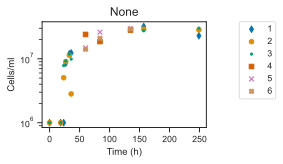

In [95]:
#Make a plot of cells and concentrations vs. time for None
#Filter by None
df_none= df_growth[(df_growth.Treatment == 'None')]
# Group by replicate
df_treatments = df_none.groupby(['Replicate'])
# Define colors
colors = sns.color_palette('colorblind', n_colors=6)
# Define markers
markers = ['d', 'o','.','s','x','X']

# Define fig and axes
#fig, ax = plt.subplots(1,7, figsize=(9,6))
fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)

# Loop through replicates
for i, (group, data) in enumerate(df_treatments):
    #print(group, data)
    ax.scatter(data.Time_h, data.cells_ml_mean,color=colors[i], marker=markers[i],
              label = group)
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Cells/ml')
    ax.set_title('None', size=12)
    ax.set_yscale('log')
    #ax.set_ylim([8e5, 7e8])

#Show legend
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0.)
#Save figure

In [96]:
#Get growth rates for the entire exponential phase
#Filter none dataframe for exponential phase only (t=0 and t=36h)
df_none_exp = df_none[(df_none.Time_h == 0) | (df_none.Time_h == 36)]
df_none_exp.head(20)

,Treatment,Replicate,Time_h,cells_ml_mean,Sulfide_mM_mean,Sulfide_mM_std
70,None,1,0.0,1000000.0,3.068434,0.051885
75,None,1,36.0,12340100.0,0.978045,0.068870
78,None,2,0.0,1000000.0,3.068434,0.051885
83,None,2,36.0,2824100.0,0.914590,0.117664
86,None,3,0.0,1000000.0,3.068434,0.051885
91,None,3,36.0,9892900.0,0.818501,0.094572


In [97]:
#Get ratios of cells/ml calculated from chlorophyll between timepoints for each ID and Replicate
df_none_exp['ratio_cells'] = df_none_exp['cells_ml_mean'].div(df_none_exp.groupby(['Treatment','Replicate'])['cells_ml_mean'].shift(1)).fillna(0) 
#Get differences between timepoints for each treatment and Replicate
df_none_exp['diff_time_h'] = df_none_exp.groupby(['Treatment','Replicate'])['Time_h'].diff().fillna(0)
#Get differences between cells/ml between timepoints for each treatment and Replicate
df_none_exp['diff_cells'] = df_none_exp.groupby(['Treatment','Replicate'])['cells_ml_mean'].diff().fillna(0)
#Get differences between sulfide concentrations between timepoints for each ID and Replicate
df_none_exp['diff_sulfide_mM'] = df_none_exp.groupby(['Treatment','Replicate'])['Sulfide_mM_mean'].diff().fillna(0)
#Calculate growth rates in day^-1
df_none_exp['growth_rate'] = np.log(df_none_exp['ratio_cells'])*24/df_none_exp['diff_time_h']
#Get maximum growth rates per ID and Replicate
df_none_exp['max_growth_rate']= df_none_exp.groupby(['Treatment','Replicate'])['growth_rate'].transform(max)
#Determine csSOR
df_none_exp['csSOR'] = -(df_none_exp['max_growth_rate']*df_none_exp['diff_sulfide_mM']*10**9)/df_none_exp['diff_cells']
#See dataframe
df_none_exp

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Treatment,Replicate,Time_h,cells_ml_mean,Sulfide_mM_mean,Sulfide_mM_std,ratio_cells,diff_time_h,diff_cells,diff_sulfide_mM,growth_rate,max_growth_rate,csSOR
70,None,1,0.0,1000000.0,3.068434,0.051885,0.0000,0.0,0.0,0.000000,-inf,1.675236,NaN
75,None,1,36.0,12340100.0,0.978045,0.068870,12.3401,36.0,11340100.0,-2.090389,1.675236,1.675236,308.806367
78,None,2,0.0,1000000.0,3.068434,0.051885,0.0000,0.0,0.0,0.000000,-inf,0.692126,NaN
83,None,2,36.0,2824100.0,0.914590,0.117664,2.8241,36.0,1824100.0,-2.153844,0.692126,0.692126,817.242739
86,None,3,0.0,1000000.0,3.068434,0.051885,0.0000,0.0,0.0,0.000000,-inf,1.527878,NaN
91,None,3,36.0,9892900.0,0.818501,0.094572,9.8929,36.0,8892900.0,-2.249933,1.527878,1.527878,386.558223


In [99]:
# Calculate the mean and standard deviation  
df_none_exp_36 = df_none_exp[(df_none_exp.Time_h == 36) & (df_none_exp.Replicate != 2)]
df_stats_none = df_none_exp_36.agg(
                    {'max_growth_rate':['mean','std'],
                     'csSOR':['mean','std']})
df_stats_none

,max_growth_rate,csSOR
mean,1.601557,347.682295
std,0.104198,54.978865
